# Credit Risk Analysis

## (1) Data Cleaning

In [1]:
import pandas as pd

Remember to inclue index_col=0 or it will generate "unnamed 0" column

In [2]:
data = pd.read_csv("FiveYearData.csv", index_col=0)

D:\Work\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (30,33,34,50,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
D:\Work\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


select the columns from Original Data File, which are information used for prediction
also select the final column:"Default" as target labels

In [3]:
data = pd.concat([data[data.columns[:26]],data[data.columns[-1]]],1)

In [4]:
data.head()

,id_loan,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,...,st,prop_type,zipcode,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,Default
0,F114Q1000001,717,201404,9,204403,39300.0,0,1,I,77,...,RI,SF,2800.0,P,360,2,Other sellers,"LAKEVIEW LOAN SERVICING, LLC",NaN,NO
1,F114Q1000002,813,201405,Y,204404,19780.0,30,1,P,95,...,IA,SF,50300.0,P,360,1,Other sellers,Other servicers,NaN,YES
2,F114Q1000004,742,201403,9,204402,NaN,0,1,P,78,...,KY,SF,42100.0,C,360,1,Other sellers,Other servicers,NaN,NO
3,F114Q1000007,735,201405,9,204404,33460.0,0,1,P,86,...,MN,SF,55000.0,N,360,2,Other sellers,Other servicers,NaN,NO
4,F114Q1000010,667,201403,N,204402,NaN,25,1,P,90,...,KY,SF,42100.0,P,360,2,Other sellers,Other servicers,NaN,NO


We can see there are NaN values. 
So first, we want to take a look at these missing values.

In [5]:
#check the missing fraction of each variable and sort them with missing fractions
missing_fractions = data.isnull().mean().sort_values(ascending=False)

In [6]:
missing_fractions[:10]

flag_sc        0.958468
cd_msa         0.100090
ppmt_pnlty     0.000623
zipcode        0.000002
Default        0.000000
orig_upb       0.000000
fico           0.000000
dt_first_pi    0.000000
flag_fthb      0.000000
dt_matr        0.000000
dtype: float64

We can see only four variables have missing values. flag_sc has a very large fraction of missing values. So we drop this variable.

In [7]:
#drop the variable with missing values over 50%
drop_list = sorted(list(missing_fractions[missing_fractions > 0.5].index))
print(drop_list)
data.drop(labels=drop_list, axis=1, inplace=True)

['flag_sc']


In [8]:
#check again the missing_fractions
missing_fractions = data.isnull().mean().sort_values(ascending=False)
missing_fractions[:10]

cd_msa         0.100090
ppmt_pnlty     0.000623
zipcode        0.000002
Default        0.000000
orig_upb       0.000000
fico           0.000000
dt_first_pi    0.000000
flag_fthb      0.000000
dt_matr        0.000000
mi_pct         0.000000
dtype: float64

In [9]:
#check the three variables with some missing values one by one
data.cd_msa.sample(10)

666986     22420.0
789142     16580.0
1317716    43524.0
792361         NaN
870416     37460.0
1799975    47664.0
1100690    34980.0
1931597    49180.0
1984917    47894.0
713917         NaN
Name: cd_msa, dtype: float64

In [10]:
#fill missing values with the median of this column
data.cd_msa.fillna(data.cd_msa.median(),inplace=True)

In [11]:
data.ppmt_pnlty.describe()

count     2097286
unique          1
top             N
freq      2097286
Name: ppmt_pnlty, dtype: object

In [12]:
#there's only one unique value for ppmt_pnlty, we can fill it with this value 'N'
#but actually, this column should be dropped since it has only one unique value
# data.ppmt_pnlty.fillna('N',inplace = True)
data.drop(['ppmt_pnlty'],axis=1, inplace=True)

In [13]:
data.zipcode.describe()

count    2.098588e+06
mean     5.615361e+04
std      2.976084e+04
min      6.000000e+02
25%      3.050000e+04
50%      5.540000e+04
75%      8.460000e+04
max      9.990000e+04
Name: zipcode, dtype: float64

In [14]:
#similarly, fill missing zipcodes with median
data.zipcode.fillna(data.zipcode.median(),inplace=True)

Next, we want to check if there are other variables with only one unique value.

In [15]:
for col in data.columns:
    unique_list = data[col].unique().tolist()
    if len(unique_list) < 2:
        print(col)

No other unique variables, good!

### Next, do some data transformation

In [16]:
import numpy as np

In [17]:
#find the columns with numerical values.
numeric_cols = data.select_dtypes(include=[np.number]).columns
numeric_cols

Index(['fico', 'dt_first_pi', 'dt_matr', 'cd_msa', 'mi_pct', 'cnt_units',
       'cltv', 'dti', 'orig_upb', 'ltv', 'int_rt', 'zipcode', 'orig_loan_term',
       'cnt_borr'],
      dtype='object')

In [18]:
from scipy.stats import zscore

In [19]:
#apply z-score transformation to numerical columns
data[numeric_cols] = data[numeric_cols].apply(zscore)

In [20]:
#find non-numerical columns
non_numeric_cols = []
for col in data.columns:
    if not col in numeric_cols:
        non_numeric_cols.append(col)
data[non_numeric_cols]

,id_loan,flag_fthb,occpy_sts,channel,prod_type,st,prop_type,loan_purpose,seller_name,servicer_name,Default
0,F114Q1000001,9,I,R,FRM,RI,SF,P,Other sellers,"LAKEVIEW LOAN SERVICING, LLC",NO
1,F114Q1000002,Y,P,R,FRM,IA,SF,P,Other sellers,Other servicers,YES
2,F114Q1000004,9,P,R,FRM,KY,SF,C,Other sellers,Other servicers,NO
3,F114Q1000007,9,P,R,FRM,MN,SF,N,Other sellers,Other servicers,NO
4,F114Q1000010,N,P,R,FRM,KY,SF,P,Other sellers,Other servicers,NO
...,...,...,...,...,...,...,...,...,...,...,...
2098588,F118Q4244552,9,P,C,FRM,VA,SF,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION","JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",NO
2098589,F118Q4244555,N,P,R,FRM,AZ,MH,P,Other sellers,Other servicers,NO
2098590,F118Q4244558,9,P,R,FRM,FL,PU,N,Other sellers,Other servicers,NO
2098591,F118Q4244561,9,P,R,FRM,FL,SF,N,Other sellers,Other servicers,NO


We notice that prod_type looks unique, but we didn't find it in previous unique check. Why?

In [21]:
data.prod_type.describe()

count     2098593
unique          2
top           FRM
freq      2098592
Name: prod_type, dtype: object

In [22]:
data.prod_type.unique()

array(['FRM', '_'], dtype=object)

That's it! There's one sample annotated as '_'. So let's drop this column.

In [23]:
data.drop(['prod_type'],axis=1, inplace=True)

In [24]:
#define again the non-numerical columns since prod_type is dropped
non_numeric_cols = []
for col in data.columns:
    if not col in numeric_cols:
        non_numeric_cols.append(col)
data[non_numeric_cols]

,id_loan,flag_fthb,occpy_sts,channel,st,prop_type,loan_purpose,seller_name,servicer_name,Default
0,F114Q1000001,9,I,R,RI,SF,P,Other sellers,"LAKEVIEW LOAN SERVICING, LLC",NO
1,F114Q1000002,Y,P,R,IA,SF,P,Other sellers,Other servicers,YES
2,F114Q1000004,9,P,R,KY,SF,C,Other sellers,Other servicers,NO
3,F114Q1000007,9,P,R,MN,SF,N,Other sellers,Other servicers,NO
4,F114Q1000010,N,P,R,KY,SF,P,Other sellers,Other servicers,NO
...,...,...,...,...,...,...,...,...,...,...
2098588,F118Q4244552,9,P,C,VA,SF,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION","JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",NO
2098589,F118Q4244555,N,P,R,AZ,MH,P,Other sellers,Other servicers,NO
2098590,F118Q4244558,9,P,R,FL,PU,N,Other sellers,Other servicers,NO
2098591,F118Q4244561,9,P,R,FL,SF,N,Other sellers,Other servicers,NO


#### Next, we can create dummy variables for these categorical variables.

But pd.dummy_variables() failed with Memory Error, so I created a manual function, which maps each unique value to an integer starting from 0

In [25]:
def replace_cate(data, non_numerical_cols):
    '''
    This function is for creating dummy variables for non_numerical columns
    '''
    list_cols = data.columns
    #exclude id_loan 
    for col in non_numeric_cols[1:]:
        col_dict = {}
        count = 0
        unique_list = data[col].unique().tolist()
        for val in unique_list:
            col_dict[val] = count
            count += 1
        getattr(data,col).replace(col_dict,inplace=True)

In [26]:
replace_cate(data, non_numeric_cols)

In [27]:
data[non_numeric_cols].sample(5)

,id_loan,flag_fthb,occpy_sts,channel,st,prop_type,loan_purpose,seller_name,servicer_name,Default
5053,F114Q1014659,1,1,2,23,1,0,2,5,0
1033690,F116Q3044109,2,1,0,22,0,0,0,1,0
1903666,F118Q2246625,2,1,1,6,2,0,13,28,0
971724,F116Q2261837,2,1,1,29,1,0,3,11,0
1751495,F118Q1054627,0,0,0,13,0,0,0,1,0


We can see these categorical variables are mapped to integers, but some variables, like st, have too many discrete values.
so we may need to create bins for them.

Before that,we drop the id_loan variable since it's a unique label for each sample.

In [28]:
data = data[data.columns[1:]]

## (2) Feature Selection with WoE

In [29]:
import scorecardpy as sc

()Split train and test set with a ratio 7:3

In [30]:
train, test = sc.split_df(data,
                          y = 'Default',
                          ratio = 0.7, seed = 251120887).values()

In [31]:
train.to_csv('train_noWoE.csv', index=False)
test.to_csv('test_noWoE.csv', index=False)

Create woe bins with scorecardpy. The parameters are set as default according to the sample code.

In [32]:
bins = sc.woebin(train, y = 'Default', 
                 min_perc_fine_bin=0.05, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.1, # Minimum information value 
                 max_num_bin=8, # Maximum number of bins
                 method='tree')

[INFO] creating woe binning ...
Binning on 1469015 rows and 23 columns in 00:02:02


In [33]:
bins

{'prop_type':     variable         bin   count  count_distr    good    bad   badprob  \
 0  prop_type  [-inf,1.0)  939934     0.639840  916923  23011  0.024482   
 1  prop_type   [1.0,2.0)  406411     0.276655  396156  10255  0.025233   
 2  prop_type   [2.0,inf)  122670     0.083505  120074   2596  0.021162   
 
         woe    bin_iv  total_iv breaks  is_special_values  
 0  0.002903  0.000005  0.001994    1.0              False  
 1  0.033911  0.000323  0.001994    2.0              False  
 2 -0.146182  0.001666  0.001994    inf              False  ,
 'int_rt':   variable          bin   count  count_distr    good    bad   badprob  \
 0   int_rt  [-inf,-1.0)  205968     0.140208  203541   2427  0.011783   
 1   int_rt   [-1.0,0.0)  585446     0.398530  574145  11301  0.019303   
 2   int_rt    [0.0,1.0)  442295     0.301083  428077  14218  0.032146   
 3   int_rt    [1.0,inf)  235306     0.160179  227390   7916  0.033641   
 
         woe    bin_iv  total_iv breaks  is_special_values

In [34]:
train_woe = sc.woebin_ply(train, bins) # Calculate WoE dataset (train)
test_woe = sc.woebin_ply(test, bins) # Calculate WoE dataset (test)

[INFO] converting into woe values ...
Woe transformating on 1469015 rows and 22 columns in 00:01:25
[INFO] converting into woe values ...
Woe transformating on 629578 rows and 22 columns in 00:00:37


In [35]:
train_woe.head()

,Default,prop_type_woe,cnt_borr_woe,fico_woe,dt_first_pi_woe,zipcode_woe,flag_fthb_woe,ltv_woe,seller_name_woe,orig_upb_woe,...,orig_loan_term_woe,int_rt_woe,servicer_name_woe,mi_pct_woe,st_woe,occpy_sts_woe,cd_msa_woe,dti_woe,channel_woe,cltv_woe
0,0,0.002903,-0.473960,0.575011,0.436541,-0.103746,-0.094816,0.000873,0.033468,0.297761,...,0.098139,0.330173,0.389026,-0.144198,-0.370673,-0.268599,0.014734,0.342912,-0.051472,0.001630
1,1,0.002903,0.325955,-0.944679,0.436541,0.235901,0.275187,0.486070,0.033468,-0.024860,...,0.098139,-0.240037,0.389026,0.498586,-0.370673,0.021392,-0.206203,-0.313873,-0.051472,0.481614
5,0,0.033911,-0.473960,-0.944679,0.436541,0.008610,-0.094816,-0.529525,0.033468,-0.103938,...,0.098139,0.283160,0.389026,-0.144198,-0.370673,0.021392,0.014734,-0.313873,-0.051472,-0.524847
7,0,0.002903,-0.473960,0.575011,0.436541,0.008610,-0.028471,0.486070,0.033468,-0.024860,...,0.098139,0.330173,-0.184301,0.498586,0.083016,0.021392,0.014734,0.342912,-0.051472,0.481614
8,0,0.002903,-0.473960,-0.944679,0.436541,0.235901,-0.028471,0.000873,0.033468,0.297761,...,0.098139,0.283160,0.389026,0.216515,-0.370673,0.021392,0.014734,-0.835846,-0.051472,0.001630


In [36]:
bins.get('dt_first_pi')

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,dt_first_pi,"[-inf,-1.0)",191758,0.130535,184610,7148,0.037276,0.436541,0.030779,0.18519,-1.0,False
1,dt_first_pi,"[-1.0,1.0)",973955,0.662999,947818,26137,0.026836,0.097143,0.006554,0.18519,1.0,False
2,dt_first_pi,"[1.0,inf)",303302,0.206466,300725,2577,0.008496,-1.071616,0.147857,0.18519,inf,False


Compute the Information Values for each variable.

In [37]:
sc.iv(train_woe, 'Default')

,variable,info_value
18,fico_woe,0.519928
2,dt_first_pi_woe,0.185190
1,servicer_name_woe,0.162174
6,st_woe,0.160729
3,dti_woe,0.158976
5,cnt_borr_woe,0.152531
0,int_rt_woe,0.123810
20,cltv_woe,0.079670
11,ltv_woe,0.079478
12,mi_pct_woe,0.062753


We can observe that some variables have IV<0.02,which must be dropped.
and some between 0.02 and 0.1, which are suggested to drop. 
I set a medium threshold 0.05, and drop those IV < 0.05

In [38]:
drop_list = ['cnt_units_woe','prop_type_woe','channel_woe','occpy_sts_woe','loan_purpose_woe',
            'flag_fthb_woe','orig_upb_woe','cd_msa_woe','seller_name_woe','orig_loan_term_woe','zipcode_woe','dt_matr_woe']
train_woe.drop(labels=drop_list, axis=1, inplace=True)

In [39]:
train_woe.columns

Index(['Default', 'cnt_borr_woe', 'fico_woe', 'dt_first_pi_woe', 'ltv_woe',
       'int_rt_woe', 'servicer_name_woe', 'mi_pct_woe', 'st_woe', 'dti_woe',
       'cltv_woe'],
      dtype='object')

In [40]:
test_woe.drop(labels=drop_list, axis=1, inplace=True)

In [41]:
#store these woe data
train_woe.to_csv("train_woe.csv", index = False)
test_woe.to_csv("test_woe.csv", index = False)

Next, we want to compute correlations between variables to get some insights of unknown correlations.

In [42]:
corr = train_woe.corr()

In [45]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [44]:
#It's necessary to keep numpy<0.18.4, or seaborn.diverging_palette will fail.
np.__version__

'1.17.4'

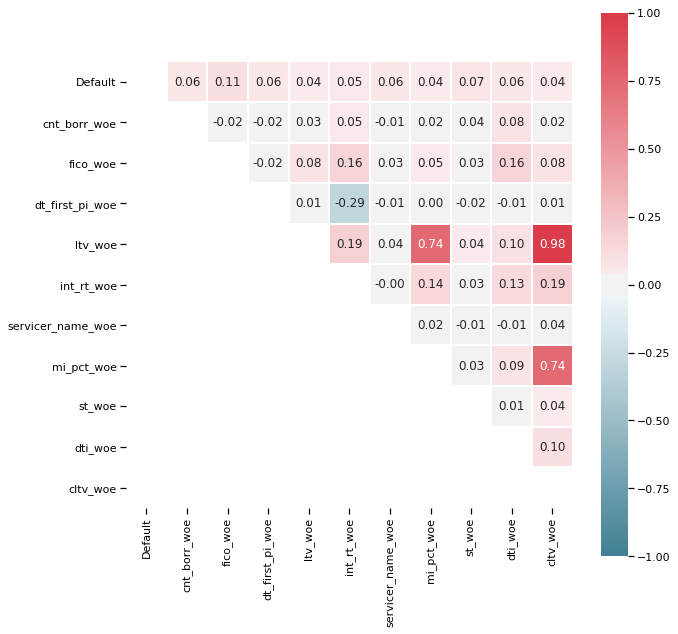

In [45]:
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, annot=True,fmt="0.2f",center=0, ax=ax, mask=mask)

We find that (ltv_woe, cltv_woe, mi_pct_woe) have high correlations. We should pay attention to these variables.
But for the moment, we don't drop any of them.

## (3) Scorecard model with Logistic Regression

In [34]:
#read data files if necessary
train_woe = pd.read_csv('train_woe.csv')
test_woe = pd.read_csv('test_woe.csv')
train_noWoE = pd.read_csv('train_noWoE.csv')
test_noWoE = pd.read_csv('test_noWoE.csv')

,Default,cnt_borr_woe,fico_woe,dt_first_pi_woe,ltv_woe,int_rt_woe,servicer_name_woe,mi_pct_woe,st_woe,dti_woe,cltv_woe
0,0,-0.473960,0.575011,0.436541,0.000873,0.330173,0.389026,-0.144198,-0.370673,0.342912,0.001630
1,1,0.325955,-0.944679,0.436541,0.486070,-0.240037,0.389026,0.498586,-0.370673,-0.313873,0.481614
2,0,-0.473960,-0.944679,0.436541,-0.529525,0.283160,0.389026,-0.144198,-0.370673,-0.313873,-0.524847
3,0,-0.473960,0.575011,0.436541,0.486070,0.330173,-0.184301,0.498586,0.083016,0.342912,0.481614
4,0,-0.473960,-0.944679,0.436541,0.000873,0.283160,0.389026,0.216515,-0.370673,-0.835846,0.001630
...,...,...,...,...,...,...,...,...,...,...,...
1469010,0,0.325955,-0.944679,-1.071616,0.000873,0.283160,0.389026,-0.144198,0.083016,0.342912,0.001630
1469011,0,-0.473960,-0.944679,-1.071616,0.000873,-0.240037,0.389026,-0.144198,0.874519,0.342912,0.001630
1469012,0,-0.473960,0.575011,-1.071616,-0.529525,0.330173,0.389026,-0.144198,0.874519,0.342912,-0.524847
1469013,0,0.325955,0.575011,-1.071616,-0.529525,0.330173,0.389026,-0.144198,-0.248311,0.342912,0.001630


In [68]:
from sklearn.linear_model import LogisticRegressionCV

LRClassifier = LogisticRegressionCV(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                                     Cs = 10,        # How many parameters to try. Can also be a vector with parameters to try.
                                     tol=0.0001, # Tolerance for parameters
                                     cv = 3,     # How many CV folds to try. 3 or 5 should be enough.
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=251120887, # Random seed
                                     max_iter=100, # Maximum iterations
                                     verbose=0, # Show process. 1 is yes.
                                     solver = 'saga', # How to optimize.
                                     n_jobs = 2,      # Processes to use. Set to number of physical cores. 
                                     refit = True     # If to retrain with the best parameter and all data after finishing.
                                    )

In [69]:
LRClassifier.fit(X = train_woe.iloc[:, 1:], # All rows and from the second var to end
                    y = train_woe['Default'] # The target  
                   )

D:\Work\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Work\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Work\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Work\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
D:\Work\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", 

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=2, penalty='l1',
           random_state=251120887, refit=True, scoring=None, solver='saga',
           tol=0.0001, verbose=0)

The LR model cannot converge. But it costs too much time to run this, so we do not add more trials like increasing the max iteration number. 

Let's check the parameters

In [71]:
coef_df = pd.concat([pd.DataFrame({'column': train_woe.columns[1:]}), 
                    pd.DataFrame(np.transpose(LRClassifier.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,cnt_borr_woe,2.736585
1,fico_woe,1.450336
2,dt_first_pi_woe,0.316423
3,ltv_woe,0.558673
4,int_rt_woe,3.713497
5,servicer_name_woe,2.695035
6,mi_pct_woe,-2.699068
7,st_woe,0.813105
8,dti_woe,1.235007
9,cltv_woe,0.427771


In [72]:
LRClassifier.intercept_

array([0.04831135])

Apply trained model to test data

In [83]:
test_woe['Default'].sum() 

15369

In [73]:
pred_class_test = LRClassifier.predict(test_woe.iloc[:, 1:])
probs_test = LRClassifier.predict_proba(test_woe.iloc[:, 1:])
pred_class_test.sum()

221978

It looks the model predict many more good loans as default.

Check the classification results.

In [74]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

In [75]:
#Calculate confusion matrix
confusion_matrix_lr = confusion_matrix(y_true = test_woe['Default'], 
                    y_pred = pred_class_test)


confusion_matrix_lr

array([[403120, 211089],
       [  4480,  10889]], dtype=int64)

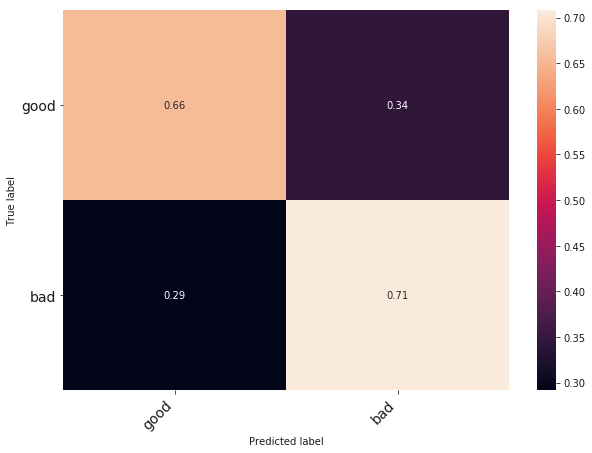

D:\Work\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [76]:
# # Turn matrix to percentages
confusion_matrix_lr = confusion_matrix_lr.astype('float') / confusion_matrix_lr.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_lr, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

In [77]:
from sklearn.metrics import classification_report

print("LR",classification_report(test_woe['Default'], pred_class_test, target_names=None,digits=4))

LR              precision    recall  f1-score   support

          0     0.9890    0.6563    0.7890    614209
          1     0.0491    0.7085    0.0918     15369

avg / total     0.9661    0.6576    0.7720    629578



The precision, recall and F1-score looks not so bad though. Let's look at AUC.

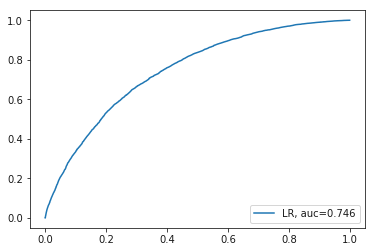

D:\Work\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [78]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test['Default'], probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test['Default'], 
                             y_score = probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.legend(loc=4)
plt.show()

The AUC score is not very ideal.:(

Create scorecard.

In [79]:
# Calculate scorecard
LR_sc = sc.scorecard(bins, LRClassifier, 
             train_woe.columns[1:], # The column names in the trained LR
             points0=750, # Base points
             odds0=0.01, # Base odds
             pdo=50) # PDO 

NameError: name 'bins' is not defined

In [89]:
# Applying the credit score. Applies over the original data!
train_score = sc.scorecard_ply(train, LR_sc, 
                               print_step=0)
test_score = sc.scorecard_ply(test, LR_sc, 
                               print_step=0)

C:\Users\23607\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\23607\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [67]:
train_score.describe()

NameError: name 'train_score' is not defined

### Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

#Define the classifier
RFClassifier = RandomForestClassifier(n_estimators=1000, # Number of trees to train
                       criterion='gini', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=2, # Minimum samples to create a split.
                       min_samples_leaf=0.001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='auto', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=251120887, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced'
                                    )

In [38]:
# Train the RF.
RFClassifier.fit(train_noWoE.iloc[:,:-1], # X 
               train_noWoE['Default'])   # y

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 11.2min finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0001,
            min_impurity_split=None, min_samples_leaf=0.001,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=True,
            random_state=251120887, verbose=1, warm_start=False)

In [39]:
rf_pred_class_test = RFClassifier.predict(test_noWoE.iloc[:, :-1])
rf_probs_test = RFClassifier.predict_proba(test_noWoE.iloc[:, :-1])

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   11.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:   13.8s finished


In [42]:
confusion_matrix_rf = confusion_matrix(y_true = test_noWoE['Default'], 
                    y_pred = rf_pred_class_test)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]
confusion_matrix_rf

array([[0.74717889, 0.25282111],
       [0.24269634, 0.75730366]])

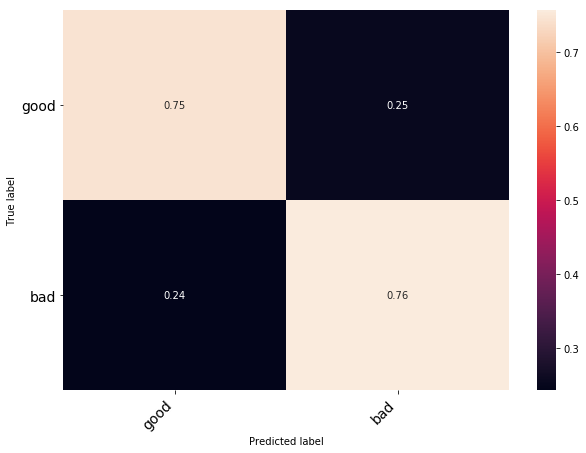

In [46]:

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

The confusion matrix looks much better than Logistic Regression.

In [47]:
from sklearn.metrics import classification_report

print("RF",classification_report(test_woe['Default'], rf_pred_class_test, target_names=None,digits=4))

RF              precision    recall  f1-score   support

          0     0.9919    0.7472    0.8523    614209
          1     0.0697    0.7573    0.1277     15369

avg / total     0.9694    0.7474    0.8346    629578



But the recall and F1-score is inferior to Logistic Regression.

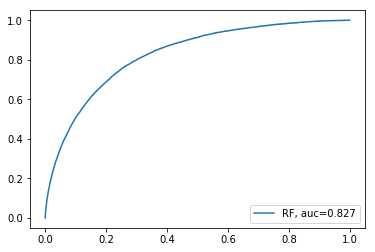

In [48]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test['Default'], rf_probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test['Default'], 
                             y_score = rf_probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="RF, auc="+str(auc))
plt.legend(loc=4)
plt.show()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXcAAAD8CAYAAACMwORRAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzt3Xt8ldWd7/HPLzcSSEISQiAkgYCA3K/hYq23gpZ2LFalFeqtHVo7M7U9U6edOp1znI4zp51aW6vnUFuqtuqoeDlWqaXF8VatLZegCHI1QCAXQm7knuxkZ6/zRyITQyCbsJMne+f7fr3yYj97r+z9W0n4ZmXt9azHnHOIiEhkifK6ABERCT2Fu4hIBFK4i4hEIIW7iEgEUriLiEQghbuISARSuIuIRCCFu4hIBFK4i4hEoBivXjg9Pd3l5uZ69fIiImFpx44dlc650b218yzcc3Nzyc/P9+rlRUTCkpkdDaadpmVERCKQwl1EJAIp3EVEIpDCXUQkAincRUQiUK/hbmaPmFm5mb1/hsfNzB4wswIz22VmC0JfpoiInItgRu6/Blac5fFPAVM6P24DHjz/skRE5Hz0us7dOfemmeWepck1wGOu43p9W8wsxcwynXPHQ1SjiMiAc87RHnD4A4629gD+dofPH6CtPYDP305di7/j8faOdm2BAO3tjqpGH7HRUTS3tdPQ4scfcAQCjoCDgHM451g2fQxzc1L6tf5QnMSUBRR1OS7uvO+0cDez2+gY3TN+/PgQvLSIyH9zztHg81PT1EZtc1uX261UNrRSVN1ES1s79S1+WvztnKjzER8bRWV9K42tfobFRNHqD1DX4u+3Gs0gIzk+LMLderivx6tuO+fWA+sB8vLydGVuETkj5xxNre2U1/uobvRx8EQDrf4Atc1t7C+rIzoqiuZWP7XNbZxsaqO6sZX6ljba2s8eLVEGCbHRjEtJIDY6iviYaOaPT6GptZ1RI+JIToglNtpo8LUzOjGO+LhoYqOiiIk2osxoaw8wJjmeYTFRtLU7UkfEEhsdRXSUERvV8W9MtDEyIZaEuGjiY6KJMogywwzMeorM0AtFuBcDOV2Os4HSEDyviESQQMBR3+KnstFHeZ2PfcfrKKlpxoDS2mZa/Q6fv53a5jbKalsor/ed8bmShsXQ3NbO1DFJJMXHMCUjkdQRcSTHxzJqRByJ8TGkjYhjRFwMqSNiSY6PJW1EHMPjogcsXL0WinDfCNxuZhuAJUCt5ttFhgbnHHUtfkprmimv91Fe1xHKJTXNVNT7KKxsJCY6ipONrZTVtZzxedJGxNHc2s7kjERGJcaRnZpAdFQUIxNimJudQnriMMYkx5OeGEfK8DjiYrSKuze9hruZPQVcDqSbWTHwL0AsgHPu58Am4NNAAdAEfKm/ihWRgRUIOCobfVTUd3xsOVxNS1s7xSebOVbdyNGqJnz+wBk/PyctgaToKC6enE5G8jCcg4ykYUwaPYLs1OGMHRlP4jDP9i+MaMGsllnTy+MO+FrIKhKRAdXS1k5BeQOHKhrYXlhNWW0Lx2tb2F9WT3ug5/nraWOTyE4dzsWT0xmbHE/q8DjGpSSQmRJPUnwMqcPjiI3W6NpL+pUpEuFqm9s4XtvM4YpGmlvb+aAzyIuqm6hsaOVkU+tHQnxscjzTM5OYkpEIQE7acGZkJpM6Io7MkfHkpA4nKmpozFuHM4W7SJhzzlFe72NvaR0HT9Rzos7H8dpmjlY1cay6iQbfR5f1xUQZE9NHMGHUcOaPTyU9MY7JGYlkJMUzf3wK8bHRHvVEQknhLhIGWtraKattYVdJLXtKazla2USLv53CykbK6lpoafvovHd6YhyzskaSl5vaMV0yMp6MpHgykoeRlZKgAB8CFO4ig0hTq5/CyiYKKhrYW1p3avpkf1n9aW0zR8YzLyeF5dPHkJWawIRRw8lKGU5u+nCGxSi8hzqFu4gHapva2HO8lq2Hqymv93GoooFtR6o/0iYmyshNH0FOagJLJqaRlZrAwgmpTBubzAitMJFe6CdEpB/VNLXyXnEtR6saOXiing9ONFBQ3kBVY+tH2s3LSeG6+VkkJ8RywegRzB+fyuSMRE2fSJ8p3EVCpD3geK+4hj99UMme0lpO1PnYWVRz6vERcdFMGZPE5RdmMGn0CGZkJjNlTCJZKQlD5qxJGTgKd5E+amsPsP94PTuLTrLlSDV/PFDxkZUp40bG89XLJpE3IY1ZWcmMTY5XiMuAUbiLBMHnb2dH4UmOVDWyu7iW7YXVFFY1nVofnpE0jE9My2DppFHMGJfM7KyRRGstuHhI4S5yBk2tft48WMkL75bwxsHyU8sNE4fFkJebylUzxzJ1TCLzclLJHTVco3IZVBTuIp3aA479ZXW8uq+c7YXVbD1cTWt7gNThsaxamM3SSaOYNjaJC0YnKshl0FO4y5B2pLKRp7cX8fKeMkpqmk9tgjU8LpobFuVw5YwxLJ00SrsQSthRuMuQUlTdxKv7TrCntI78oyc5UtkIwJjkjjnzy6aOZsGEVKaOSfK4UpHzo3CXiBYIOHYcO8kr+07wX3tOcLgzzAGWTctg9aIcLr8wgwvHKswlsijcJeL4/O28caCC1/eX88q+ciobfJjBRZNGsXpxDrOzUlgyMU07G0pEU7hLRCitaeaNAxW8ebCCtw9VUt/iJ3FYDJddOJpl0zK4dOpo0hOHeV2myIBRuEtYavT5eXlvGa/vr2DbkepTl3BLTxzGJ2eO5eo5mXzsgnS9ESpDlsJdwsaJuhZe3nuCPx6o4M+HKmlqbSd1eCyXTh3N7KyRXDw5nQvHJGm6RQSFuwxyx2ubeS6/mM17y3i/pA6ArJQErp6TyWfnZbF00iiFuUgPFO4y6JTUNLNxZymbdh9nd0ktAAvGp/Ctq6ZyxbQMZmQm6yQikV4o3GVQaPT5eWFnCRu2FZ0K9BmZyXz7kxfy6dmZTEwf4XGFIuFF4S6ecc7xdkEVz79TzEu7j9PqDzB1TCLfWTGNZdMzdCKRyHlQuMuAK61p5untRbyws4SjVU0ArFk8ns/MzeSiSaM05SISAgp3GRDNre38Yc9xnthyjB3HTuIcLMpN5bZLJ3HNvCwSddk4kZDS/yjpV82t7Tz4x0P87PUC/AFHeuIwVi8az1cvnUSu5tFF+o3CXfpFIODYvKeM+145yMETDVxx4WhuvmgCl0/N0NJFkQGgcJeQqmlq5entRWzYXsSRykbGJsez/uaFXDVzrNeliQwpCncJiZqmVp7YeoxH/1xIeb2P2Vkj+ekN8/irOZnERmsLAJGBpnCX83KiroVH/nSEJ7ceo97nJ29CKg/etJCFE1K9Lk1kSFO4S58UVjbyq7eP8OS2Y7S1O5ZNy+D2T0xm/niFushgEFS4m9kK4H4gGnjIOfcf3R4fDzwKpHS2udM5tynEtcogUFDewH2vHOR3u44DsHLuOG7/xGSdcCQyyPQa7mYWDawDrgSKge1mttE5t7dLs/8JPOOce9DMZgCbgNx+qFc8cqCsnnv+sJ9X95cTHWV8bmE2t39iMhNGaTmjyGAUzMh9MVDgnDsMYGYbgGuAruHugOTO2yOB0lAWKd45WtXIj18+yO92Hyc+JoqvXXEBt1yUy5jkeK9LE5GzCCbcs4CiLsfFwJJubb4HvGxmXwdGAMtDUp14xjnH8++UcNeL79MWcKxelMMdV05llK5mJBIWggn3ns44cd2O1wC/ds792MwuAh43s1nOucBHnsjsNuA2gPHjx/elXulngYDj6fwi1r95mCOVjUwbm8SDNy3UrowiYSaYcC8GcrocZ3P6tMtaYAWAc+4vZhYPpAPlXRs559YD6wHy8vK6/4IQjx08Uc+3n32P94prmZuTwg+vn831C7KJ0Tp1kbATTLhvB6aY2USgBFgNfKFbm2PAMuDXZjYdiAcqQlmo9J/6ljbu+cMBntp2jOFx0dz7ublcNz9L2wSIhLFew9055zez24HNdCxzfMQ5t8fM7gbynXMbgX8Afmlm36RjyuaLzjmNzAe59oDj2fwi/s9rBZTUNLNm8XjuuHIqo5M0ry4S7oJa5965Zn1Tt/vu6nJ7L3BxaEuT/hIIOP6wp4wfbT7AkcpGZmUl8+PPz2XppFFelyYiIaIzVIeYfcfr+ObTO9lfVs+k0SP42Y0L+NSssbpAhkiEUbgPEc45fv7Hw9z78gGS42O4Z9Ucrp2fpU29RCKUwn0IeK+ohn/97R7eOVbDVTPG8P3rZpOu9eoiEU3hHuEe/tMRvr9pHykJsXz/2tmsXpSjVTAiQ4DCPUI557hn8wEefOMQl0xJ5/7V80kbEed1WSIyQBTuEai6sZV/en4Xm/ec4Lr5WXz/utnEx0Z7XZaIDCCFe4TZXVzL1596h+KTzXzrqqn83eWTNQ0jMgQp3CNEIOBY/9Zh7vnDftJGDOOJLy9hidatiwxZCvcI0NLWzh3P7GTT7jKWTx/DvZ+bQ8pwza+LDGUK9zBX3djKbY/lk3/0JH+/fAr/Y9kUnZAkIgr3cLa3tI5bf7WNqgYf935uLqsWZntdkogMEgr3MPWnDypZ++h2kuJjefFrH2d29kivSxKRQUThHoY27ynj9iffITt1OI/99WJy0oZ7XZKIDDIK9zCz5XAV33jqXWaMG8kjt+bpsnci0iOFexh5aVcp//jcLsalJPCrLy7SGacickbaEjBMbNh2jNuffJcLxybx1FeWKthF5Kw0ch/k2gOOe1/+7z1ifnlLnrYSEJFeKdwHMZ+/ne88t4sXdpayamE2//7ZWQp2EQmKwn2Q8vnb+cpjO3jzYIVOThKRc6ZwH4SqG1v56uP5bC88yf+6egZrPz7R65JEJMwo3AeZ2qY2Pv+Lv3C0qpEfrZrD5/JyvC5JRMKQwn0QKa9r4QsPbeVoVSMP3bqIy6aO9rokEQlTCvdBorqxlZse3krxySZ+9cXFfHxKutcliUgYU7gPAlUNPm58aCuFVU386ouLuHiygl1Ezo/C3WNHqxr5ymP5FFY28YubFyrYRSQkFO4eKqttYfX6LTT6/Dx0ax6Xao5dREJE4e6R4pNNfOlX26lpamPDbUuZm5PidUkiEkEU7h6obPBxyyPbqKj38fAX8xTsIhJyCvcB1uDzs/bX2yk52czja5eweGKa1yWJSATSrpADqLm1na88ms/ukloeWDNfwS4i/UYj9wESCDi++p872HKkih9cO5tPzhzrdUkiEsGCGrmb2QozO2BmBWZ25xnafN7M9prZHjN7MrRlhjfnHHe/tJc3D1bwz5+ezurF470uSUQiXK8jdzOLBtYBVwLFwHYz2+ic29ulzRTgn4CLnXMnzSyjvwoOR4+8Xciv/1zITUvH89cXaxMwEel/wYzcFwMFzrnDzrlWYANwTbc2XwHWOedOAjjnykNbZvh6v6SWH2zax7JpGdy9chZRUdq2V0T6XzDhngUUdTku7ryvq6nAVDN728y2mNmKnp7IzG4zs3wzy6+oqOhbxWGkvK6Frz/1LinDY/nhqjkKdhEZMMGEe0+J5LodxwBTgMuBNcBDZnba4m3n3HrnXJ5zLm/06Mg+G7OlrZ0vP5ZPaU0zD960kPTEYV6XJCJDSDDhXgx03VQ8Gyjtoc2Lzrk259wR4AAdYT9kffc3u9lVXMv9q+exKFdLHkVkYAUT7tuBKWY20czigNXAxm5tXgCuADCzdDqmaQ6HstBw8of3j/P8OyXcfsVkVszK9LocERmCeg1355wfuB3YDOwDnnHO7TGzu81sZWezzUCVme0FXge+7Zyr6q+iB7NDFQ1869ldzMpK5hvLhvQfLyLioaBOYnLObQI2dbvvri63HXBH58eQ1dYe4B+eeY8og/U35xEXoxOARcQbOkM1hH7+xiF2FtVw/+p5jEtJ8LocERnCNLQMka2Hq/jJKwdZMXMsK+eO87ocERniFO4hUFLTzNeefIfxacO59/NzMdN6dhHxlsL9PAUCjjue3klzazu/vCWPxGGa6RIR7yncz9Mjbx9h65FqvvtX05k6JsnrckREAIX7eSmqbuLelw+wbFoGX9BOjyIyiCjc+6jVH+DrT72Lc/C9lTM1zy4ig4omiPvof/9u76lljzlpw70uR0TkIzRy74MXd5bw6F+OctPS8Vwzr/sGmSIi3lO4n6OC8nq++/xuFk5I5a6rZ3pdjohIjxTu56Cp1c+XH80nPjaa//uF+dpeQEQGLc25n4N7Nx+ksKqJ/1y7hMyR2l5ARAYvDT2D9H5JLY/+pZBr52fx8SnpXpcjInJWCvcg3bP5ACMTYrnr6hlelyIi0iuFexDeL6nlzYMVfPFjuaSOiPO6HBGRXince+Gc4/ub9pEyPJZbLprgdTkiIkFRuPfiP7ce48+Hqvjm8qmkDNeoXUTCg8L9LCrqfdzz+/0smZjGzUs1aheR8KFwP4tfvnWYhlY/d18zi6go7R0jIuFD4X4GhZWN/OrtI1w3P5sLx2orXxEJLwr3M1j/1mHMjG99cqrXpYiInDOFew+OVTXxbH4R183P0pmoIhKWFO49+P6mfcRGR/H3yzVqF5HwpHDvZmdRDX/YU8Ztl05i7Mh4r8sREekThXs3979ykLQRcfz1xyd6XYqISJ8p3LvYX1bH6wcquPWiXJLjY70uR0SkzxTuXfz0vz5gRFy0thkQkbCncO9UUF7Py3vLuOmiCdocTETCnsK9089eP0RMVBRfuWSS16WIiJw3hTtQVN3Ei++VcstFE0hPHOZ1OSIi5y2ocDezFWZ2wMwKzOzOs7RbZWbOzPJCV2L/e/hPRzDgyxq1i0iE6DXczSwaWAd8CpgBrDGz0y5HZGZJwDeAraEusj8VlDfw+JajfHZ+lta1i0jECGbkvhgocM4dds61AhuAa3po92/APUBLCOvrdz97vYBoM/5xxYVelyIiEjLBhHsWUNTluLjzvlPMbD6Q45x7KYS19bvDFQ1sfK+UNYtzyEjSqF1EIkcw4d7TRubu1INmUcB9wD/0+kRmt5lZvpnlV1RUBF9lP3nwjUNERRl/c/kFXpciIhJSwYR7MZDT5TgbKO1ynATMAt4ws0JgKbCxpzdVnXPrnXN5zrm80aNH973qEDha1cj/e6eYNYtytPOjiEScYMJ9OzDFzCaaWRywGtj44YPOuVrnXLpzLtc5lwtsAVY65/L7peIQefwvRzEzvnqZRu0iEnl6DXfnnB+4HdgM7AOecc7tMbO7zWxlfxfYH5pa/Ty9vYgVs8YyLkWjdhGJPDHBNHLObQI2dbvvrjO0vfz8y+pfG3eWUu/z66LXIhKxhtwZqs45ntp2jEmjR7BkYprX5YiI9IshF+5bj1TzXnEtX/pYLmY9LQQSEQl/Qy7cn8kvImlYDJ/Ly+m9sYhImBpS4d7g87Np93GunptJfGy01+WIiPSbIRXuG3eW0tIW0KhdRCLe0Ar390rIHTWcBeNTvS5FRKRfDZlwL6xsZMvhaj47P6v3xiIiYW7IhPvvdh8H4POakhGRIWBIhLtzjie3HmNxbprOSBWRIWFIhPvOohpKapr5/CKN2kVkaBgS4f7b944TFx3FVTPHeF2KiMiAiPhwbw84frurlMsvHE1yfKzX5YiIDIiID/f8wmoq6n1cPXec16WIiAyYiA/3F3aWEB8bxSemZXhdiojIgInocPf523npveN8elYmicOC2t1YRCQiRHS4/9feE9T7/HxmnqZkRGRoiehwf2LLMXLSErhsirfXaxURGWgRG+61TW1sOVLFyrnjiIrSvu0iMrREbLj/qaAS5+CyqXojVUSGnogN99+/f5z0xDgWjE/xuhQRkQEXkeEeCDj+cqiKS6aMJiY6IrsoInJWEZl87xXXUNXYyscnp3tdioiIJyIy3DfvOUFMlLF8hvaSEZGhKSLD/bX9J1iUm8bIBO0lIyJDU8SFe2lNMwdPNHDpVK1tF5GhK+LCfVPnFZc+qe19RWQIi7hw/+PBCqaOSWTS6ESvSxER8UxEhXt7wPHO0ZMsnTTK61JERDwVUeG+v6yOxtZ2FoxP9boUERFPRVS4/7mgCoDFE9M8rkRExFsRFe5vflDBlIxExqUkeF2KiIinggp3M1thZgfMrMDM7uzh8TvMbK+Z7TKzV81sQuhLPbv2gOPdYzUatYuIEES4m1k0sA74FDADWGNmM7o1exfIc87NAZ4D7gl1ob05XNFAg8/PfM23i4gENXJfDBQ45w4751qBDcA1XRs45153zjV1Hm4BskNbZu+2HKkG0C6QIiIEF+5ZQFGX4+LO+85kLfD7nh4ws9vMLN/M8isqKoKvMghvHawgKyWBiekjQvq8IiLhKJhw7+kyRq7HhmY3AXnAj3p63Dm33jmX55zLGz06dNsDBAKOrUeq+fjkdMx01SURkZgg2hQDOV2Os4HS7o3MbDnwz8BlzjlfaMoLTkFFA7XNbeTlar5dRASCG7lvB6aY2UQziwNWAxu7NjCz+cAvgJXOufLQl3l27xw9CaA3U0VEOvUa7s45P3A7sBnYBzzjnNtjZneb2crOZj8CEoFnzWynmW08w9P1i22F1aQnxnHBaM23i4hAcNMyOOc2AZu63XdXl9vLQ1zXOXnn6EkWjE/VfLuISKewP0O1vqWNo9VNzBiX7HUpIiKDRtiH+/sldTgHc7O1vl1E5ENhH+7vFnW8mTo3R+EuIvKhsA/3PaV15KQlkDYizutSREQGjbAP993FtczMHOl1GSIig0pYh3tlg49j1U0smKApGRGRrsI63HcV1wB6M1VEpLuwDvcDZQ0ATMvUMkgRka7COtyPVDaQnjiMkQmxXpciIjKohHW47ztez4VjE70uQ0Rk0AnbcHfOcbiigcmjFe4iIt2FbbiX1/tobG1nksJdROQ0YRvuH5zoeDN1yhiFu4hId2Eb7gXl9QCalhER6UHYhvsH5Q0kx8cwOmmY16WIiAw6YRvuhyoamJyRqD3cRUR6ELbhfrSqidxRuvKSiEhPwjLcW/0ByupayEkb7nUpIiKDUliG+/HaZpyDrNQEr0sRERmUwjLcj1Y1AWhaRkTkDMIy3EtrmgHIHBnvcSUiIoNTjNcF9MXx2hbMYEyywl0kGG1tbRQXF9PS0uJ1KRKk+Ph4srOziY3t28aIYRruzaQnDiMuJiz/8BAZcMXFxSQlJZGbm6vlw2HAOUdVVRXFxcVMnDixT88RlulYVufTlIzIOWhpaWHUqFEK9jBhZowaNeq8/tIKy3AvPtnEuJFaKSNyLhTs4eV8v19hGe4VdT4yUzRyFwkn0dHRzJs3j1mzZvGZz3yGmpqOy2QWFhaSkJDAvHnzTn20trZ6XG2HI0eOsGTJEqZMmcINN9zQY11tbW3ceuutzJ49m+nTp/ODH/wAgKKiIq644gqmT5/OzJkzuf/++099zg033HCqr7m5ucybNy/ktYdduDf6/NT7/NpTRiTMJCQksHPnTt5//33S0tJYt27dqccuuOACdu7ceeojLi7Ow0r/23e+8x2++c1v8sEHH5CamsrDDz98Wptnn30Wn8/H7t272bFjB7/4xS8oLCwkJiaGH//4x+zbt48tW7awbt069u7dC8DTTz99qq/XX3891113XchrD7twL6/3ATAmSSN3kXB10UUXUVJS0qfPbWhoYNmyZSxYsIDZs2fz4osvAh1/AcyaNetUu3vvvZfvfe97ABQUFLB8+XLmzp3LggULOHToUK+v45zjtddeY9WqVQDceuutvPDCC6e1MzMaGxvx+/00NzcTFxdHcnIymZmZLFiwAICkpCSmT59+Wp+dczzzzDOsWbOmT1+Lswm71TJVDR3hnq6Ru0if/Otv97C3tC6kzzljXDL/8pmZQbVtb2/n1VdfZe3atafuO3To0KmpiYsvvvgjo/ru4uPj+c1vfkNycjKVlZUsXbqUlStXnvU1b7zxRu68806uvfZaWlpaCAQC1NfXc8kll/TY/sknnyQjI4OUlBRiYjpiMjs7u8dfSKtWreLFF18kMzOTpqYm7rvvPtLS0j7SprCwkHfffZclS5Z85P633nqLMWPGMGXKlLPW3xdhF+71Pj8ASfFhV7rIkNbc3My8efMoLCxk4cKFXHnllace+3BaJhjOOb773e/y5ptvEhUVRUlJCSdOnDhj+/r6ekpKSrj22muBjl8OHzrba1ZUVJx2X09vcm7bto3o6GhKS0s5efIkl1xyCcuXL2fSpElAx18a119/PT/96U9JTk7+yOc+9dRT/TJqhyDD3cxWAPcD0cBDzrn/6Pb4MOAxYCFQBdzgnCsMbakdGjvDPXGYwl2kL4IdYYfah3PutbW1XH311axbt45vfOMb5/w8TzzxBBUVFezYsYPY2Fhyc3NpaWkhJiaGQCBwqt2Hywidcz0+T28j9+nTp1NTU4Pf7ycmJobi4mLGjRvXY9sVK1YQGxtLRkYGF198Mfn5+UyaNIm2tjauv/56brzxxtPm1f1+P88//zw7duw4569BMHqdczezaGAd8ClgBrDGzGZ0a7YWOOmcmwzcB/ww1IV+qLm1HYCE2Oj+egkR6UcjR47kgQce4N5776Wtre2M7bZt28Ytt9xy2v21tbVkZGQQGxvL66+/ztGjRwEYM2YM5eXlVFVV4fP5eOmllwBITk4mOzv71Hy5z+ejqamJpKSkj7yJ2/VjxowZmBlXXHEFzz33HACPPvoo11xzzWn1jB8/ntdeew3nHI2NjWzZsoVp06bhnGPt2rVMnz6dO+6447TPe+WVV5g2bRrZ2dnn/kUMQjBvqC4GCpxzh51zrcAGoHsPrwEe7bz9HLDM+mlRbYu/4zdzvMJdJGzNnz+fuXPnsmHDhjO2OXbsGAkJp5/PcuONN5Kfn09eXh5PPPEE06ZNAyA2Npa77rqLJUuWcPXVV5+6H+Dxxx/ngQceYM6cOXzsYx+jrKwsqDp/+MMf8pOf/ITJkydTVVV16n2CjRs3ctdddwHwta99jYaGBmbNmsWiRYv40pe+xJw5c3j77bd5/PHHee21104te9y0adOp596wYUO/TckA2Jn+ZDnVwGwVsMI59+XO45uBJc6527u0eb+zTXHn8aHONpVnet68vDyXn59/zgU/9NZh/v13+9j1vatIju/bngsiQ81PjXXQAAAE8ElEQVS+ffuYPn2612Wck29/+9vcfPPNzJkzx+tSPNPT983Mdjjn8nr73GAmrnsagXf/jRBMG8zsNuA26PhTpi/Gpw3nU7PGalpGJML96Ec/8rqEsBZMuBcDOV2Os4HSM7QpNrMYYCRQ3f2JnHPrgfXQMXLvS8FXzRzLVTPH9uVTRUSGjGDm3LcDU8xsopnFAauBjd3abARu7by9CnjN9TbfIyIi/abXkbtzzm9mtwOb6VgK+Yhzbo+Z3Q3kO+c2Ag8Dj5tZAR0j9tX9WbSInDvnnDYPCyPnOz4OarG4c24TsKnbfXd1ud0CfO68KhGRfhMfH09VVZW2/Q0TH+7n3vWEq3OlM4FEhoDs7GyKi4t7POtSBqcPr8TUVwp3kSEgNja2z1f0kfAUdrtCiohI7xTuIiIRSOEuIhKBet1+oN9e2KwCONrHT08Hzri1QYRSn4cG9XloOJ8+T3DOje6tkWfhfj7MLD+YvRUiifo8NKjPQ8NA9FnTMiIiEUjhLiISgcI13Nd7XYAH1OehQX0eGvq9z2E55y4iImcXriN3ERE5i0Ed7ma2wswOmFmBmd3Zw+PDzOzpzse3mlnuwFcZWkH0+Q4z22tmu8zsVTOb4EWdodRbn7u0W2VmzszCfmVFMH02s893fq/3mNmTA11jqAXxsz3ezF43s3c7f74/7UWdoWJmj5hZeeeV6np63Mzsgc6vxy4zWxDSApxzg/KDju2FDwGTgDjgPWBGtzZ/B/y88/Zq4Gmv6x6APl8BDO+8/bdDoc+d7ZKAN4EtQJ7XdQ/A93kK8C6Q2nmc4XXdA9Dn9cDfdt6eARR6Xfd59vlSYAHw/hke/zTwezquZLcU2BrK1x/MI/dBdWHuAdJrn51zrzvnmjoPt9BxZaxwFsz3GeDfgHuAloEsrp8E0+evAOuccycBnHPlA1xjqAXTZwckd94eyelXfAsrzrk36eGKdF1cAzzmOmwBUswsM1SvP5jDPQso6nJc3Hlfj22cc36gFhg1INX1j2D63NVaOn7zh7Ne+2xm84Ec59xLA1lYPwrm+zwVmGpmb5vZFjNbMWDV9Y9g+vw94CYzK6bj+hFfH5jSPHOu/9/PyWDe8jdkF+YOI0H3x8xuAvKAy/q1ov531j6bWRRwH/DFgSpoAATzfY6hY2rmcjr+OnvLzGY552r6ubb+Ekyf1wC/ds792MwuouPqbrOcc4H+L88T/Zpfg3nkfi4X5uZsF+YOI8H0GTNbDvwzsNI55xug2vpLb31OAmYBb5hZIR1zkxvD/E3VYH+2X3TOtTnnjgAH6Aj7cBVMn9cCzwA45/4CxNOxB0ukCur/e18N5nAfihfm7rXPnVMUv6Aj2MN9HhZ66bNzrtY5l+6cy3XO5dLxPsNK51y+N+WGRDA/2y/Q8eY5ZpZOxzTN4QGtMrSC6fMxYBmAmU2nI9wj+dJRG4FbOlfNLAVqnXPHQ/bsXr+j3Mu7zZ8GDtLxLvs/d953Nx3/uaHjm/8sUABsAyZ5XfMA9PkV4ASws/Njo9c193efu7V9gzBfLRPk99mAnwB7gd3Aaq9rHoA+zwDepmMlzU7gKq9rPs/+PgUcB9roGKWvBf4G+Jsu3+N1nV+P3aH+udYZqiIiEWgwT8uIiEgfKdxFRCKQwl1EJAIp3EVEIpDCXUQkAincRUQikMJdRCQCKdxFRCLQ/wdzecO5mXMqBgAAAABJRU5ErkJggg==

But the AUC is much better.

### XGBoost

In [52]:
from xgboost import XGBClassifier
#Define the classifier.
XGB_loan = XGBClassifier(max_depth=3,                 # Depth of each tree
                            learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=2,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=0.632,              # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=251120887,        # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [54]:
# Define the parameters. 
param_grid = dict({'n_estimators': [50, 100, 150],
                   'max_depth': [2, 3, 4],
                 'learning_rate' : [0.01, 0.05, 0.1, 0.15]
                  })


# Create validation set
val_train = train_noWoE.sample(frac = 0.5,               # The fraction to extract
                                       random_state = 251120887    # The seed.
                                       )


In [56]:
from sklearn.model_selection import GridSearchCV

# Define grid search object.
GridXGB = GridSearchCV(XGB_loan,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = 3,              # Number of cross-validation folds.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = 2,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [57]:
# Train grid search.
GridXGB.fit(val_train.iloc[:, :-1], val_train['Default'])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 11.7min
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed: 28.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=None,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=None, max_depth=3,
       min_child_weight=Non...scale_pos_weight=1, subsample=0.632, tree_method=None,
       validate_parameters=None, verbosity=1),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_estimators': [50, 100, 150], 'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1, 0.15]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [58]:
# Show best params
GridXGB.best_params_

{'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 150}

In [60]:
# Create XGB with best parameters.
XGB_best = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                            learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                            n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                            verbosity=1,                  # If to show more errors or not.
                            objective='binary:logistic',  # Type of target variable.
                            booster='gbtree',             # What to boost. Trees in this case.
                            n_jobs=4,                     # Parallel jobs to run. Set your processor number.
                            gamma=0.001,                  # Minimum loss reduction required to make a further partition on a leaf node of the tree. (Controls growth!)
                            subsample=1,                  # Subsample ratio. Can set lower
                            colsample_bytree=1,           # Subsample ratio of columns when constructing each tree.
                            colsample_bylevel=1,          # Subsample ratio of columns when constructing each level. 0.33 is similar to random forest.
                            colsample_bynode=1,           # Subsample ratio of columns when constructing each split.
                            reg_alpha=1,                  # Regularizer for first fit. alpha = 1, lambda = 0 is LASSO.
                            reg_lambda=0,                 # Regularizer for first fit.
                            scale_pos_weight=1,           # Balancing of positive and negative weights.
                            base_score=0.5,               # Global bias. Set to average of the target rate.
                            random_state=251120887,        # Seed
                            missing=None                  # How are nulls encoded?
                            )

In [61]:
# Train over all training data.
XGB_best.fit(train_noWoE.iloc[:, :-1], train_noWoE['Default'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.15, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, monotone_constraints='()',
       n_estimators=150, n_jobs=4, num_parallel_tree=1,
       objective='binary:logistic', random_state=251120887, reg_alpha=1,
       reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=1)

D:\Work\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


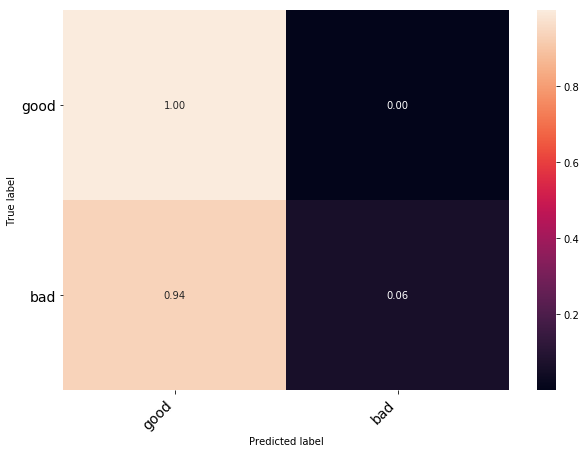

In [62]:
# Calculate probability
XGBClassTest = XGB_best.predict(test_noWoE.iloc[:, :-1])
xg_probs_test = XGB_best.predict_proba(test_noWoE.iloc[:, :-1])
xg_probs_test = xg_probs_test[:, 1]

# Calculate confusion matrix
confusion_matrix_xgb = confusion_matrix(y_true = test_noWoE['Default'], 
                    y_pred = XGBClassTest)

# Turn matrix to percentages
confusion_matrix_xgb = confusion_matrix_xgb.astype('float') / confusion_matrix_xgb.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_xgb, index=['good', 'bad'], columns=['good', 'bad'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Much worse than LR, the False Positives are too much (0.94).

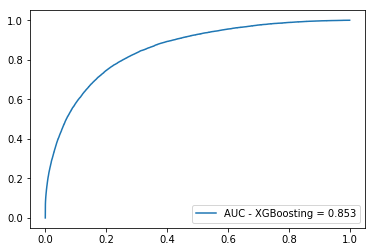

In [63]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_noWoE['Default'], 
                                 xg_probs_test)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_noWoE['Default'], 
                             y_score = xg_probs_test),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

The AUC is good. So the AUC scores for LR, RF, and XGBoost are 0.746, 0.827 and 0.853. XGBoost is the best!

## (5) Variable Importance

Next we want to evaluate the variable importances of these models.

### Random Forest

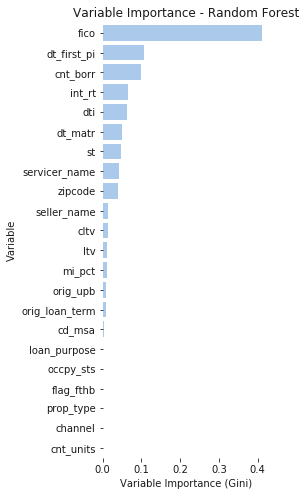

In [64]:
# Plot variable importance
importances = RFClassifier.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest")
sns.set_color_codes("pastel")
sns.barplot(y=[train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)


### XGBoost

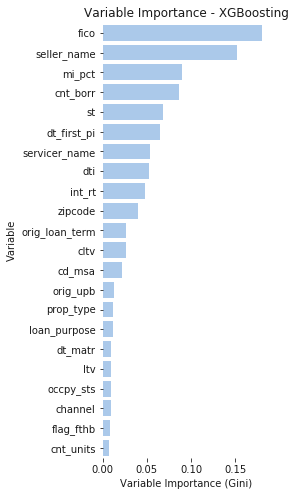

In [65]:
# Plot variable importance
importances = XGB_best.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGBoosting")
sns.set_color_codes("pastel")
sns.barplot(y=[train_noWoE.iloc[:, :-1].columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)


###  Scorecard

In [66]:
sc.iv(train_woe, 'Default')

,variable,info_value
2,fico_woe,0.519928
6,dt_first_pi_woe,0.185190
1,servicer_name_woe,0.162174
9,st_woe,0.160729
3,dti_woe,0.158976
0,cnt_borr_woe,0.152531
4,int_rt_woe,0.123810
7,cltv_woe,0.079670
5,ltv_woe,0.079478
8,mi_pct_woe,0.062753


### Two-cut-off point for scorecard